robli atandard scaler i pca wtf

nie wiadomo w sumie jak to zorbić poprawnie na tych kategorycznych

kmeans to trzeba dzielić 

# ej a może olać ten zbiór skategoryzowany i zrobić na tym raw?
# a nie bo tamten sie nawet nie otwier

może lepiej k medroids
 tse projection???
 
 tisne
 
 alstrakcyjne - nie klasteryzaja
 
 w 3 wymiarach po pca tisne
 
 
 zmienić paramtry sme
 
 mini bacz spróbować może
 
 3 metryki dla kmeans
 
 inne rzeczy na podprobce
 
 eps dla db scan z algorytmu
 
 spróbować różne metody???
 
 gnn gausian mixtue
 
 próbować nazwać te klastry?? jakiś automat???? CO
 
 koduje się zmienne, na częstości, na wykładzi kiedyś bylo
 

# Wstęp do uczenia maszynowego
##  Projekt nr 2
#### Jakub Piwko, Malwina Wojewoda

#### Pakiety

In [1]:
#!pip install mca
#!pip install prince
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import mca
import prince
import itertools
import scipy.stats as ss
from random import random, seed, randint
seed(1)
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster import hierarchy
from sklearn import cluster, datasets, mixture
from sklearn_extra.cluster import KMedoids
from yellowbrick.cluster import SilhouetteVisualizer

### Wczytanie danych oraz ich opis

Jak dowiadujemy się z opisu danych są one obrobioną nieco wersją zbioru USCensus1990raw. Zawierał  on 1 % próbki z pełnego spisu powszechnego z 1990r. W naszym pliku rekordy zostały losowo przemieszane. Aby uzyskać zbiór, którym się zajmujemy zostały wykonane następujące operacje: 
* randomizacja: rekordy z USCensus1990raw zostały losowo permutowane
* zmiany w kolumnach: kilka zmiennych ciągłych zostało zdyskretyzowane, a zmienne dyskretne, które miały dużo wartości zostało zwinięte do mniejszej liczby wartości; kolumny, które nie uległy zmianie oznaczone są prefiksem "i", a te które były zmienione - prefiksem "d"; dokładne zmieny zostały opisane w pliku *USCensus1990.mapping.sql*
* usunięto kolumny, które były mało przydatne

Można więc powiedzieć, że na danych został już wykonany preprocessing.

Pierwszym atrybutem jest caseid i powinnien on być ignorowany podczas analizy.  
Wszystkie dane są numeryczne.

In [2]:
X = pd.read_csv('USCensus1990.data.txt')
X.head()

,caseid,dAge,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,...,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,iYearwrk,dYrsserv
0,10000,5,0,1,0,0,5,3,2,2,...,0,5,0,2,1,1,0,11,1,0
1,10001,6,1,1,0,0,7,5,2,2,...,0,1,0,2,1,1,0,5,1,0
2,10002,3,1,2,0,0,7,4,2,2,...,0,2,0,2,1,1,0,10,1,0
3,10003,4,1,2,0,0,1,3,2,2,...,0,1,0,1,1,1,0,10,1,0
4,10004,7,1,1,0,0,0,0,2,2,...,3,0,0,0,2,2,0,5,6,0


Od razu możemy usunąć kolumnę `caseid` ponieważ to jedynie numer identyfuikacyjny, nic nie wnoszący do naszej dalszej analizy.

In [3]:
X.drop('caseid', inplace = True, axis = 1)

In [4]:
X.shape

(2458285, 68)

Sprawdźmy czy w zbiorze są jakieś braki danych:

In [5]:
X.isna().sum().sum()

0

In [6]:
X.isnull().sum().sum()

0

Wygląda na to, że w naszym zbiorze nie ma braków danych.

In [7]:
X.duplicated().sum()

459793

Jest dużo zduplikowanych wierszy, które zdecydowaliśmy się usunąć

In [8]:
X.drop_duplicates(inplace = True)

Sprawdzimy jeszcze jakie są unikalne wartości w każdej z kolumn:

In [9]:
pd.set_option('display.max_rows', None) 
print(X.apply(lambda col: col.unique()))

dAge                                  [5, 6, 3, 4, 7, 1, 2, 0]
dAncstry1               [0, 1, 11, 3, 2, 9, 8, 10, 4, 6, 7, 5]
dAncstry2              [1, 2, 12, 3, 4, 10, 7, 5, 11, 8, 6, 9]
iAvail                                         [0, 3, 4, 2, 1]
iCitizen                                       [0, 3, 4, 2, 1]
iClass                          [5, 7, 1, 0, 6, 3, 4, 2, 8, 9]
dDepart                                     [3, 5, 4, 0, 2, 1]
iDisabl1                                             [2, 0, 1]
iDisabl2                                             [2, 0, 1]
iEnglish                                       [1, 0, 2, 3, 4]
iFeb55                                                  [0, 1]
iFertil         [1, 3, 0, 4, 7, 2, 5, 6, 12, 8, 13, 10, 9, 11]
dHispanic                       [0, 1, 9, 2, 6, 3, 4, 8, 7, 5]
dHour89                                     [4, 1, 3, 0, 5, 2]
dHours                                      [3, 1, 4, 0, 5, 2]
iImmigr                     [0, 5, 1, 8, 3, 10, 6, 7, 4

In [10]:
pd.set_option('display.max_rows', 10) #back to default

Oryginalny zbiór jest duży, ograniczymy go do losowej jednoprocentowej próbki.

In [11]:
df = X.sample(frac=0.01, random_state=17)

In [12]:
df.shape

(19985, 68)

## Analiza danych
Przyjrzymy się wykresom wizualizującym relacje między zmiennymi, aby odkryć jakieś zależności, które mogą nam pomóc przy doborze klastrów. Przyjrzymy się bubble plotom, które pokazują liczności przecięć dwóch zmiennych.

In [13]:
def HeatMap(column1, column2):
    df1 = df.groupby([column1, column2]).size().reset_index(name='counts')
    df1 = pd.pivot(df1, index = 'race', columns = 'sex', values = 'counts')
    sns.heatmap(df1, annot=True, cmap='Reds', ax=ax1, fmt='g', norm=LogNorm())
    
def BubblePlot(column1, column2):
    df1 = df.groupby([column1, column2]).size().reset_index(name='counts')
    plt.figure(figsize = (12, 8))
    plt.scatter(df1[column1], df1[column2], s=df1['counts'], alpha = 0.7)
    plt.xlabel(column1)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
    plt.ylabel(column2)

In [14]:
df1 = df.groupby(['iMarital', 'iClass']).size().reset_index(name='counts')

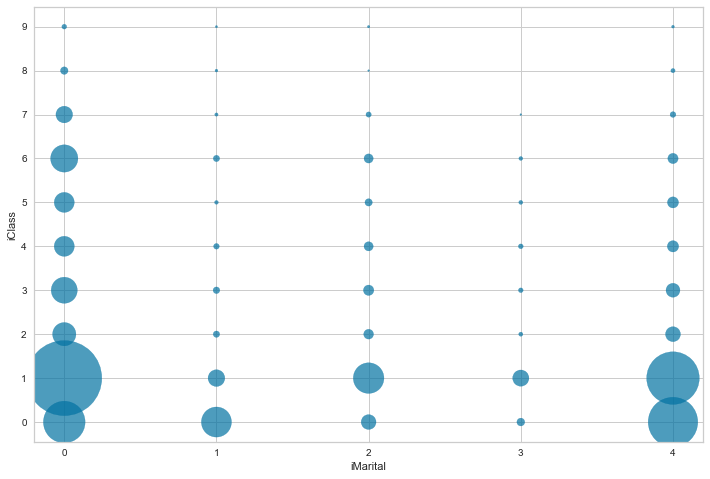

In [15]:
BubblePlot('iMarital', 'iClass')

Legenda:

|   | iMarital (marital status)          | iClass (class of worker)                          |
|---|------------------------------------|---------------------------------------------------|
| 0 | Now Married, Except Separated      | N/a Less Than 16 Yrs. Old/unemp. Who Never Worked |
| 1 | Widowed                            | Emp. of a Private for Profit Company              |
| 2 | Divorced                           | Emp. of a Private Not for Profit                  |
| 3 | Separated                          | Local Gov. Emp. City, County, Etc.                |
| 4 | Never Married or Under 15 Yrs. Old | State Gov. Emp.                                   |
| 5 |                                    | Federal Gov. Emp.                                 |
| 6 |                                    | Self Emp. in Own Not Incorp.d Business            |
| 7 |                                    | Self Emp. in Own Incorp.d Business                |
| 8 |                                    | Working Without Pay in Family Business or Farm    |
| 9 |                                    | Unemp., Last Worked in 1984 or Earlier            |

Widać, że przeważają grupy osób, które są w związku małżeńskim (1 na osi x) nigdy nie były w sformalizowanym związku lub poniiżej 15 roku życia (4 na osi x). Dodatkowo widać, że w grupie 4 na osi x, jest dużo osób, które nigdy nie były zatrudnione lub mają mniej niż 16 lat (0 na osi y), co jest dosyć intuicyjne. Dodatkowo wśród osób zamężnych jest przewaga osób pracujących prywatnie (1 na osi y)

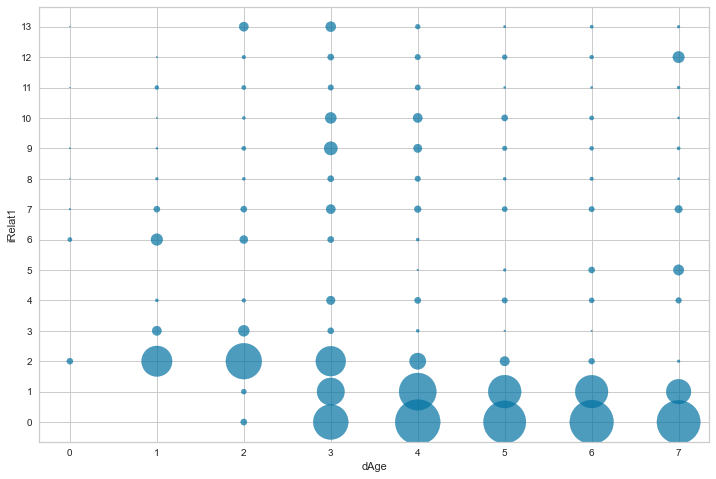

In [16]:
BubblePlot('dAge', "iRelat1")

Legenda:

|    | iRelat1 (related or not)    | dAge  |
|----|-----------------------------|-------|
| 0  | Householder                 | 0     |
| 1  | Husband/wife                | <13   |
| 2  | Son/daughter                | 13-19 |
| 3  | Stepson/stepdaughter        | 20-29 |
| 4  | Brother/sister              | 30-39 |
| 5  | Father/mother               | 40-49 |
| 6  | Grandchild                  | 50-64 |
| 7  | Other Rel.                  | >65   |
| 8  | Roomer/boarder/foster Child |       |
| 9  | Housemate/roommate          |       |
| 10 | Unmarried Partner           |       |
| 11 | Other Nonrel.               |       |
| 12 | Instit. Person              |       |
| 13 | Other Pers. in Grp. Qtrs.   |       |

Na wykresie ze zmiennymi `dAge` i `iRelat1` widać niesamowicie ciekawe i oszałamiające rzeczy. Widać, że dorosłe osoby (oznaczone numerami większymi niż 2 na osi x) są głowami rodziny (0 na osi y) i są zakawalifikowani jako mąż lub żona (1 na osi y). Natomiast osoby młodsze (1 na osi x) są kwalifikowani przede wszytskim jako dzieci, co jest spójne. 

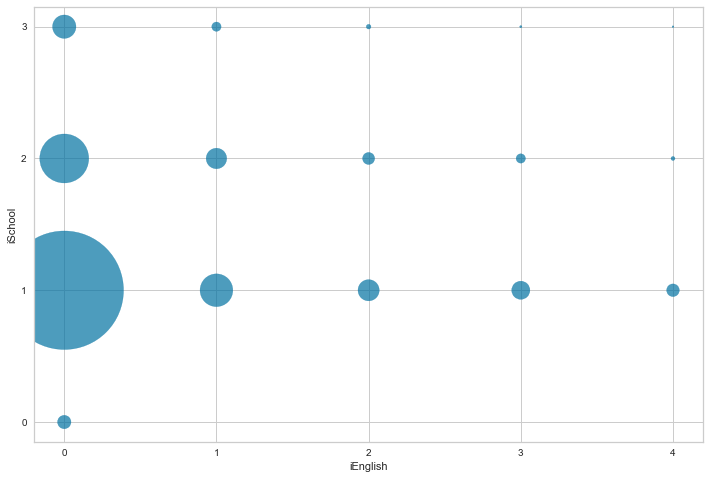

In [17]:
BubblePlot('iEnglish', 'iSchool')

Legenda: 

|    | iEnglish (ability to speak English)          | iSchool (school enrollment)        |
|----|----------------------------------------------|------------------------------------|
| 0  | N/a Less Than 5 Yrs. Old/speaks Only English | N/a Less Than 3 Yrs. Old           |
| 1  | Very well                                    | Not Attending School               |
| 2  | Well                                         | Yes, Pub. School, Pub. Coll.       |
| 3  | Not Well                                     | Yes, Private School, Private Coll. |
| 4  | Not at all                                   |                                    |

Największa grupą wśród rozważanych stanową osoby, które mówią tylko po angielsku. Wśród nich najwięcej jest osób, które nie chodzą do szkoły, czyli jak można wnioskować - dorosłych. Można też zauważyć, że więcej osób chodzi do publicznych, niż prywatnych placówek.

# !!!!!!!!!!! tu się zaczyna zmiana
## Redukcja zmiennych
Postanowiliśmy bliżej przyjrzeć się zmiennymi i usunąć płeć, która wydaje się nieodpowiednia do rozważania. 

In [18]:
X.drop(['iSex'], inplace = True, axis = 1)

Zauważylismy że zmienne `dIncome{1-8}` niosą te same informacje co zmienna `dRpincome`, jednak zdecydowaliśmy, że celem naszego klastwoania będzie podział na poszczególne zarobki, dlatego usuniemy te zmienne oraz bezpieśrednio powiązaną z nimi `dRearning` odpowiadającą za zarobki. 

In [19]:
X.drop(['dIncome1', 'dIncome2', 'dIncome3', 'dIncome4', 'dIncome5', 'dIncome6', 'dIncome7', 'dIncome8', 'dRpincome', 'dRearning'], inplace = True, axis = 1)

Zauważyliśmy też, że także w innym przypadku kilka kolumn niesie te same informacje, którą grupuje zmienna `iRvetserv` określona następująco:
- 00  --    N/a Less Than 16 Yrs. Old, No Active Dut
- 01  --   September 1980 or Later Only
- 02  --    May 1975 to August 1980 Only
- 03    --  May 1975 to August 1980 and September 19
- 04  --    Vietnam Era, No Korean Conflict, No Wwii
- 05  --    Vietnam Era and Korean Conflict, No Wwii
- 06  --    Vietnam Era and Korean Conflict and Wwii
- 07  --    February 1955 to July 1964 Only
- 08   --   Korean Conflict, No Vietnam Era, No Wwii
- 09  --    Korean Conflict and Wwii, No Vietnam Era
- 10  --    Wwii, No Korean Conflict, No Vietnam Era
- 11  --    Other Srvc.

Dlatego usuniemy nastepujące zmienne:

In [20]:
X.drop(['iFeb55', 'iSept80', 'iWWII', 'iKorean', 'iMay75880', 'iOthrserv', 'iVietnam'], inplace = True, axis = 1)

# !!!!!!! tu kończy 
#### Redukcja zmiennych: korelacja Spearmana

Przejdziemy teraz do głębszej analizy zmiennych zawartych w naszej ramce. Przyjrzymy sie mapie korelacji a także zależnościom między zmiennymi. 

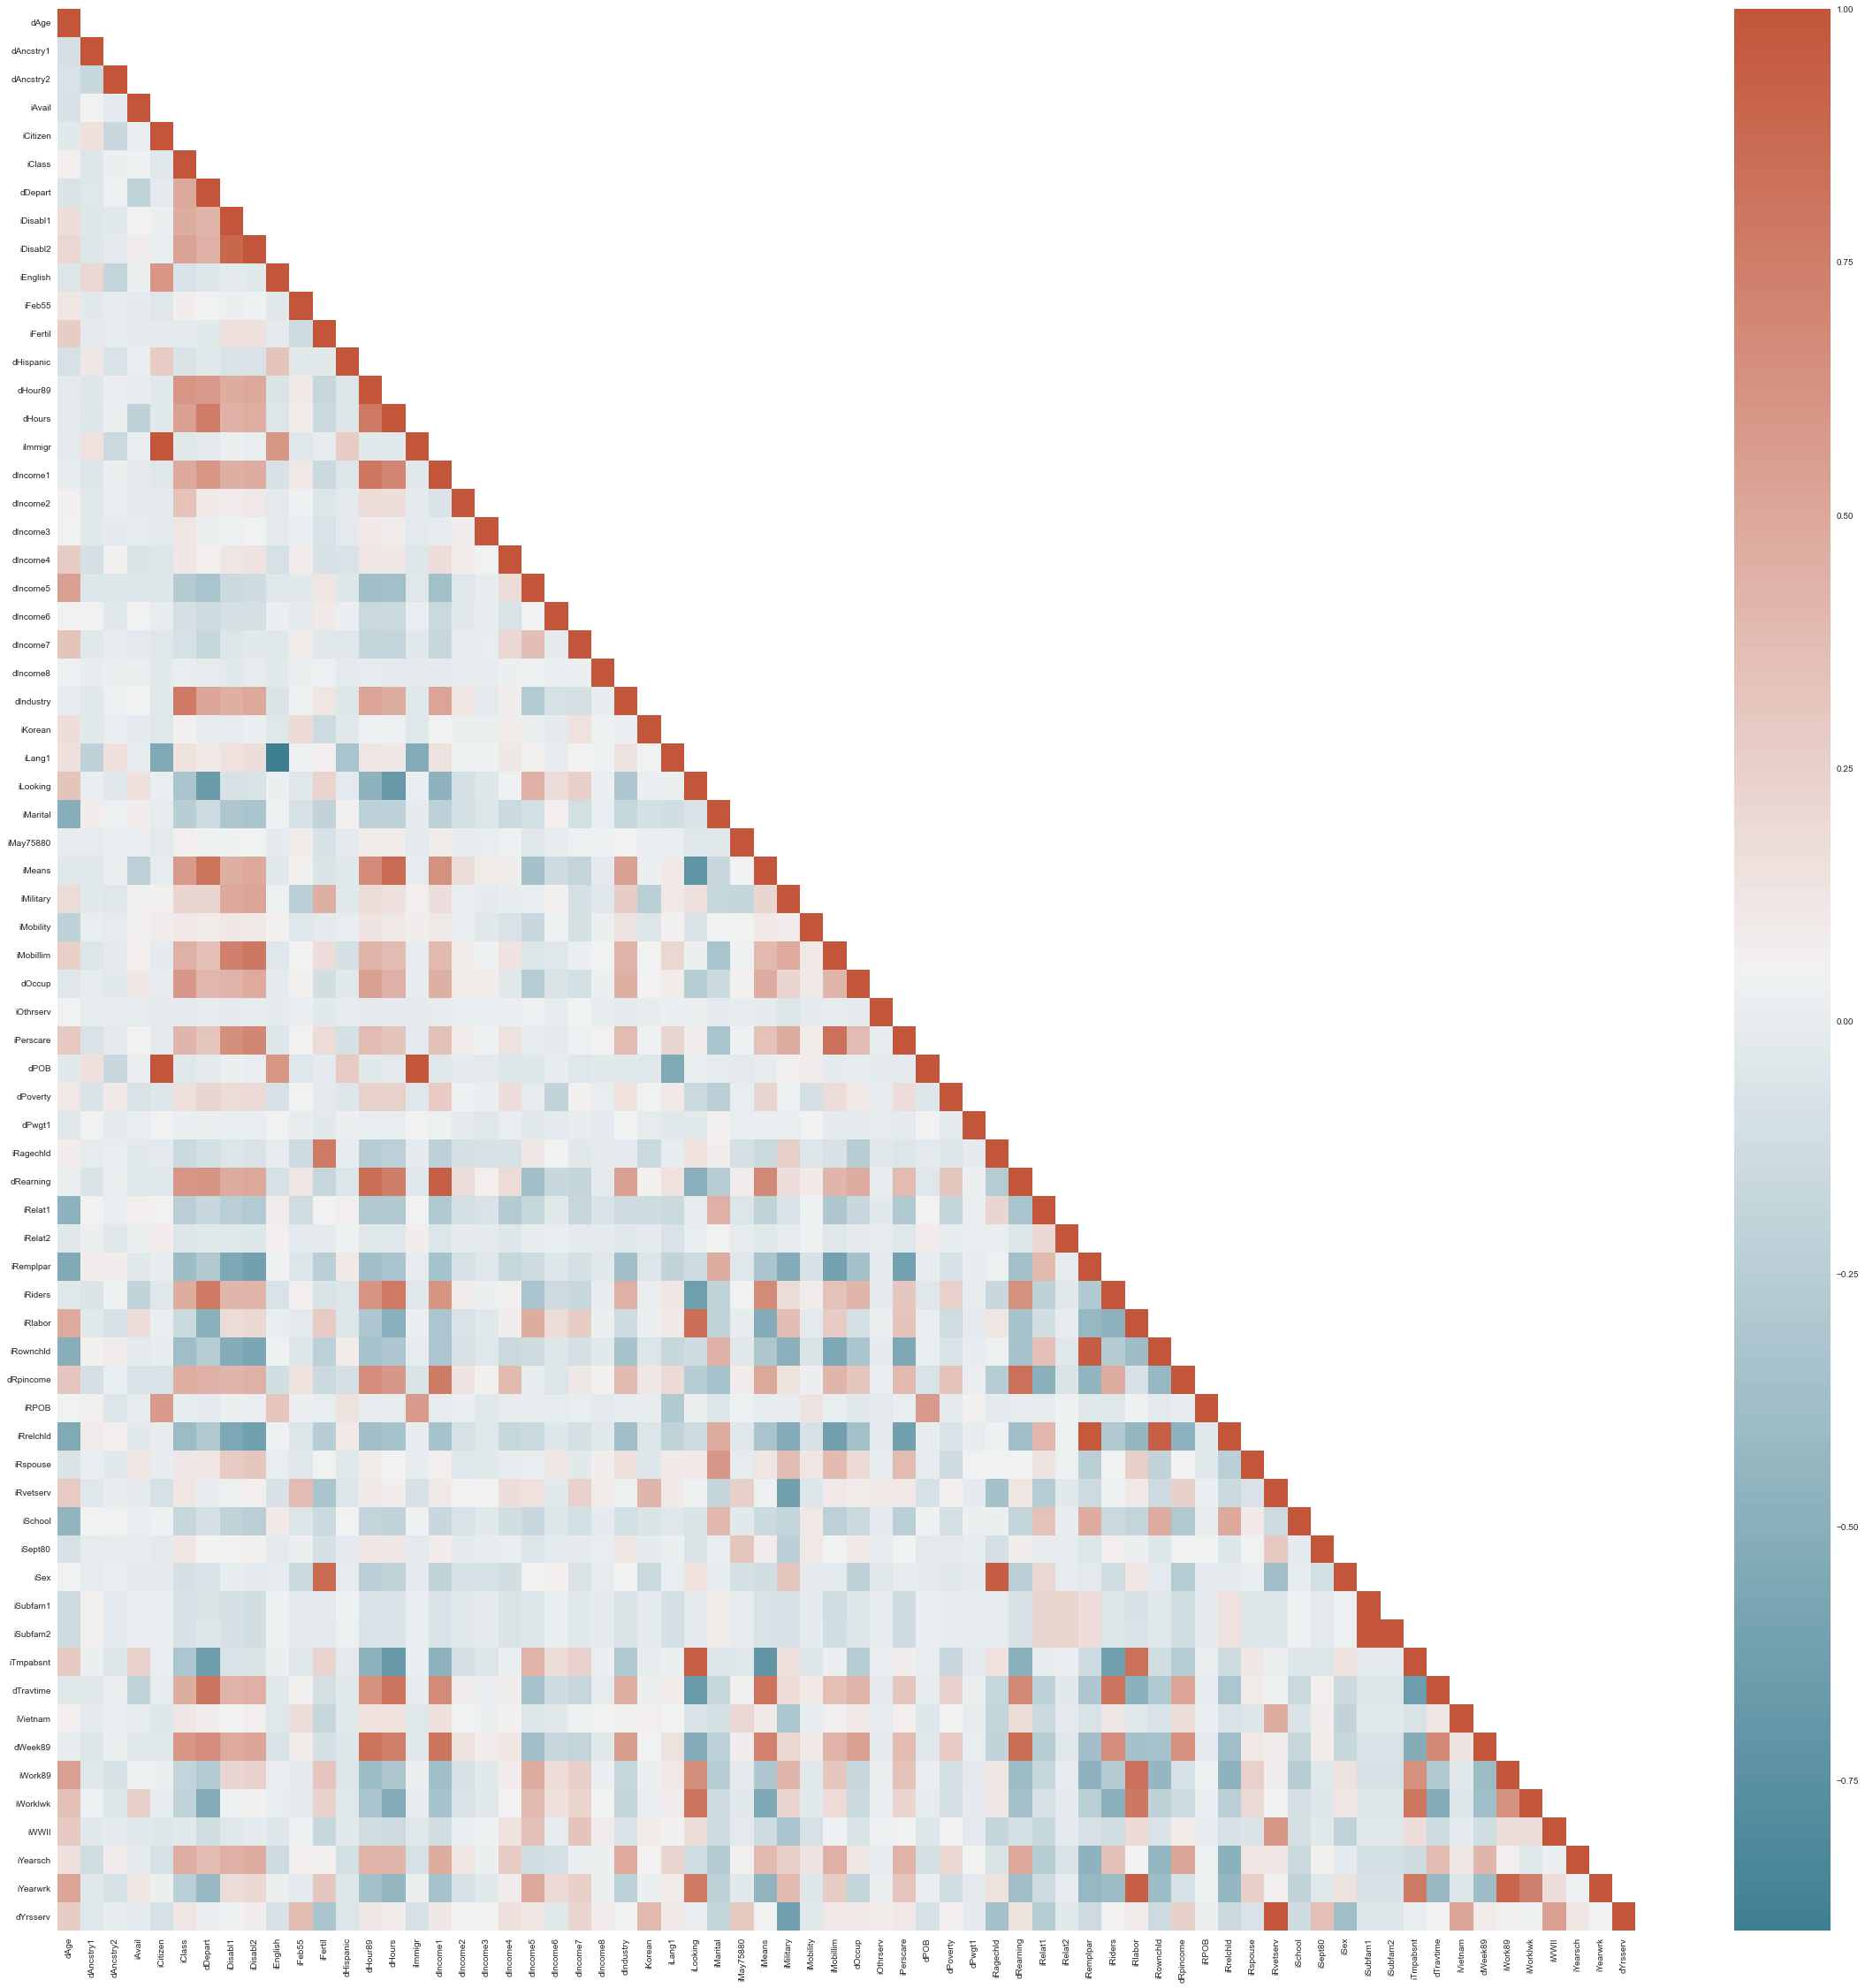

In [21]:
plt.figure(figsize=(40, 40))
df = df.corr(method = 'spearman')
custom_palette = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(df.where(np.tril(np.ones(df.shape)).astype(np.bool_)), annot=False, cmap=custom_palette)
plt.show()

Z powyższej mapy możemy odczytać, że w ramce danych występują wysoko skorelowane zmienne. Podzbędziemy się tych o najwyższym module wartości korelacji (czyli większym od 0.8). Dla każdych 2 tak skorelowanych kolumn obliczamy średnią wartość korelacji z pozostałymi kolumnami i usuwamy tę, dla której ta średnia korelacja jest większa. 

In [22]:
df = X.sample(frac=0.01, random_state=17)
corr_coeff=0.75
corr_matrix = df.corr(method = 'spearman')
corr_mean = abs(corr_matrix).mean()
features_drop_list = []
features_index_drop_list = [] 
corr_matrix = abs(corr_matrix)

for i in range(corr_matrix.shape[0]):
    for j in range(i+1,corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j]>=corr_coeff and i not in features_index_drop_list and j not in features_index_drop_list:
            if corr_mean[corr_matrix.columns[i]] >= corr_mean[corr_matrix.columns[j]]:
                features_drop_list.append(corr_matrix.columns[i])
                features_index_drop_list.append(i)
            else:
                features_drop_list.append(corr_matrix.columns[j])
                features_index_drop_list.append(j)

In [23]:
print(len(features_drop_list))
print(features_drop_list)

20
['iCitizen', 'iClass', 'dHours', 'iMeans', 'dDepart', 'iDisabl2', 'iLang1', 'iFertil', 'dWeek89', 'dPOB', 'iRlabor', 'iLooking', 'iMobillim', 'iRemplpar', 'dTravtime', 'iRrelchld', 'dYrsserv', 'iSubfam1', 'iTmpabsnt', 'iYearwrk']


#### Redukcja zmiennych: algorytm MCA

In [24]:
df_mca = X.sample(frac=0.001, random_state=17)

In [25]:
df_mca_var = mca.MCA(df_mca)

Sprawdźmy najpierw do jakiej liczby zmiennych możemy zredukować:

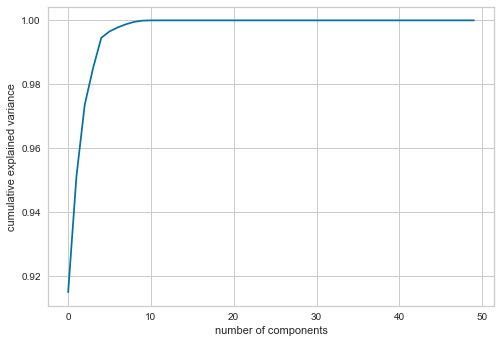

In [26]:
plt.plot(np.cumsum(df_mca_var.expl_var(greenacre=False, N=68)))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Z wykresu wynika, że najbardziej odpowiednią wartością będzie 10.

In [27]:
mca = prince.MCA(n_components=10)
mca = mca.fit(df_mca)
mca = mca.transform(df_mca)
mca

,0,1,2,3,4,5,6,7,8,9
1043419,-0.349360,0.153980,-0.299022,0.422714,0.002220,-0.799666,-0.394538,0.548863,-0.245143,0.122811
1788281,-0.374378,0.490790,-0.202956,0.000925,-0.068921,-0.139941,0.518372,-0.209870,0.042785,-0.079905
2007264,-0.440189,-0.319495,0.078671,0.047610,-0.143682,0.190745,-0.001649,-0.002302,-0.008890,-0.032898
1539732,-0.470834,-0.381913,-0.129799,-0.609940,0.618992,0.000626,-0.169620,-0.201188,0.104513,0.953558
1416737,-0.424896,0.572791,-0.532219,0.049208,-0.215613,0.226479,-0.110585,-0.025985,-0.013126,-0.052896
...,...,...,...,...,...,...,...,...,...,...
1441824,-0.392727,0.010907,-0.286442,0.099367,0.100969,-0.518106,0.306364,-0.042346,0.017846,-0.073165
1677651,-0.409473,-0.393031,-0.012829,0.235354,0.211359,-0.493056,-0.329465,-0.275805,-0.060437,-0.240896
7755,-0.426777,0.713771,-0.589517,0.113914,-0.346842,0.393703,-0.079144,-0.111056,0.074655,0.028432
216780,2.017270,-0.080014,-0.046357,0.028628,0.053390,0.001374,-0.061725,-0.014008,-0.026785,-0.023280


#### Redukcja zmiennych: współczynnik V Craméra

In [28]:
df_cramer = X.sample(frac=0.01, random_state=17)

In [29]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cols = df_cramer.columns.values.tolist()
corrM = np.zeros((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(df_cramer[col1], df_cramer[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

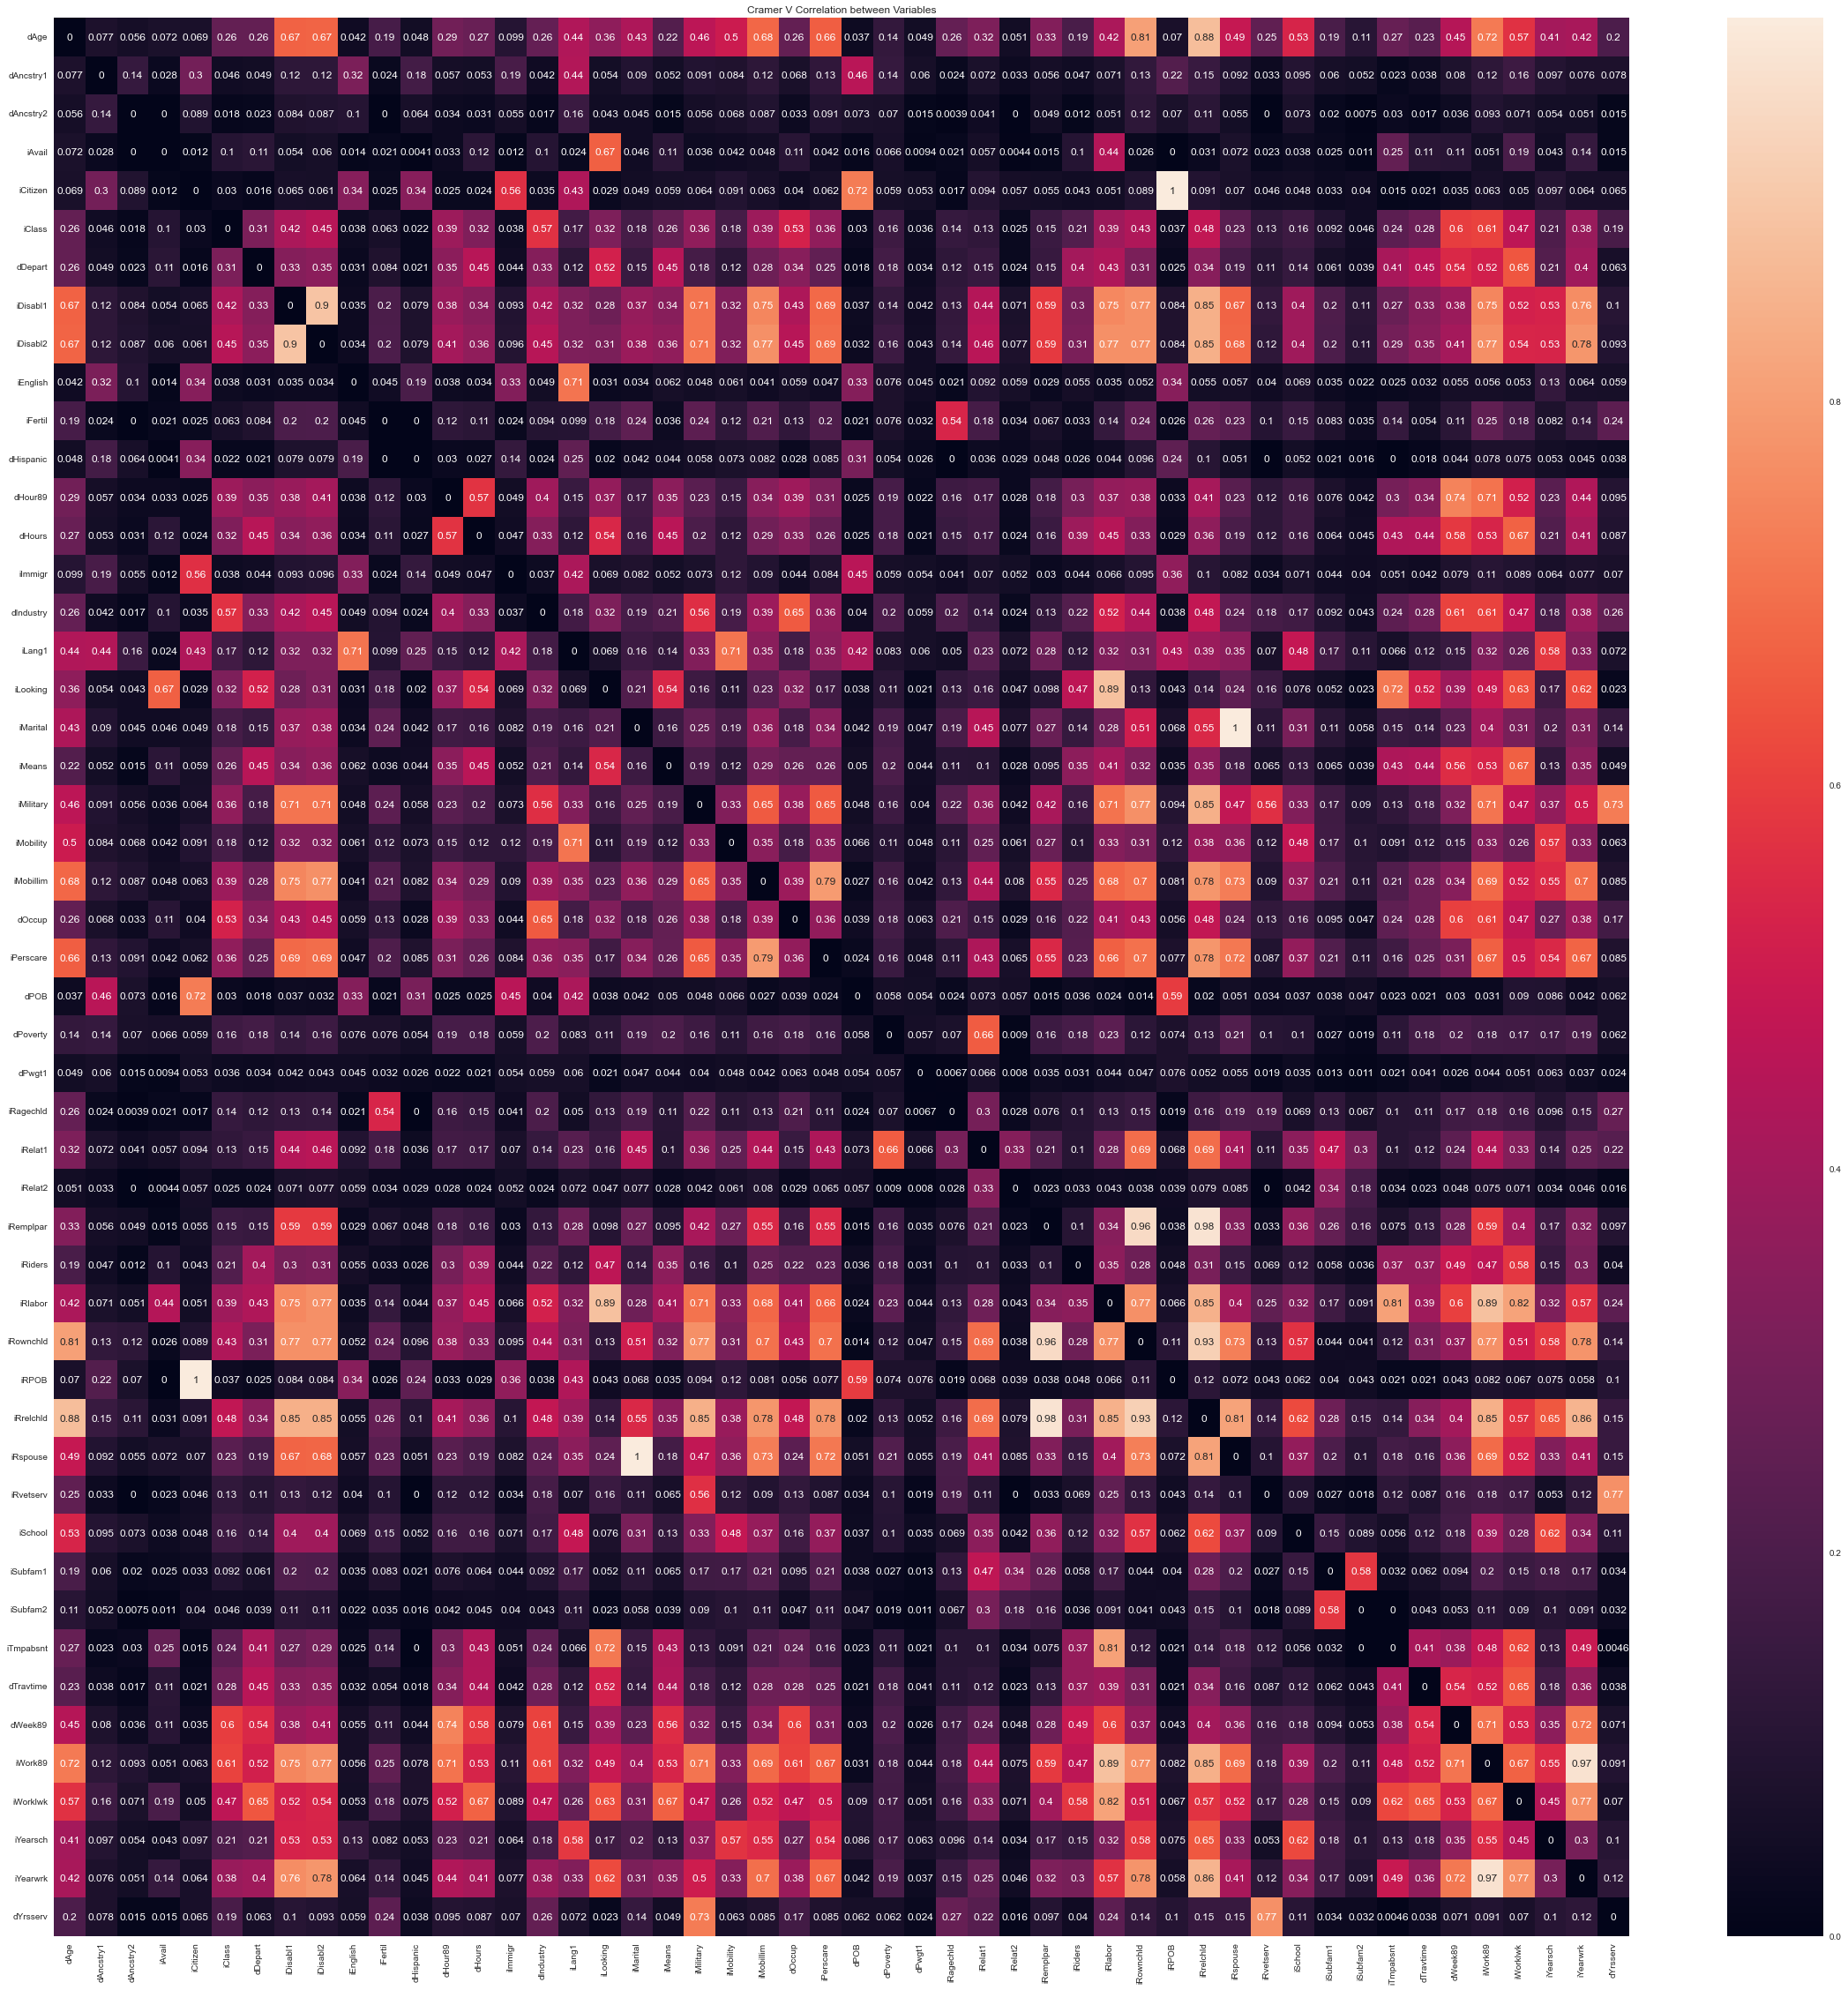

In [30]:
corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(40, 40))
ax = sns.heatmap(corr, annot=True, ax=ax);
ax.set_title("Cramer V Correlation between Variables");

Kiedy współczynnik V-Cramera jest większy niż 0.6 wskazuje to na silną korelację pomiędzy zmiennymi. W tym przypadku będzimey usuwać losową spośród wysoko skorelowanych zmiennych.

In [31]:
correlated_features = set()
for i in range(len(df_cramer.columns)):
    for j in range(i):
        if abs(cramers_v(df_cramer[df_cramer.columns[i]], df_cramer[df_cramer.columns[j]])) >= 0.6:
            random = randint(0, 1)
            if random == 0:
                correlated_features.add(df_cramer.columns[i])
            else:
                correlated_features.add(df_cramer.columns[j])
print(len(correlated_features))
print(correlated_features)

32
{'dYrsserv', 'iCitizen', 'dHour89', 'dHours', 'dPOB', 'iMarital', 'iMilitary', 'iLang1', 'dOccup', 'iYearwrk', 'iAvail', 'iMobillim', 'iRrelchld', 'dPoverty', 'iRvetserv', 'iRelat1', 'iDisabl2', 'iDisabl1', 'iYearsch', 'iRemplpar', 'iLooking', 'iMeans', 'iRownchld', 'dIndustry', 'dWeek89', 'iPerscare', 'iTmpabsnt', 'iRspouse', 'iWork89', 'iRlabor', 'iWorklwk', 'dAge'}


dla porównania usunięte przy corr Spearmana:
{'iCitizen', 'iClass', 'dHours', 'iMeans', 'iRiders', 'dTravtime', 'iDisabl2', 'iLang1', 'iFertil', 'dHour89', 'dPOB', 'dRearning', 'dIncome1', 'iRlabor', 'iLooking', 'iMobillim', 'iRagechld', 'iRemplpar', 'iRrelchld', 'dYrsserv', 'iSubfam1', 'iTmpabsnt', 'iYearwrk'}

---
---
---
## Redukcja zmiennych

Zdecydowaliśmy się na redukcję zmiennych wykonanej przy użyciu korelacji Spearmana, ponieważ mca będzie trudne w interpretowalności, a współczynnik V-Cramera określaja poziom zależności pomiędzy dwiema zmiennymi nominalnymi, spośród których co najmniej jedna przyjmuje więcej niż dwie wartości. W naszym przypadku nie wszytskie kolumny przyjmują więcej niż 2 wartości.

In [32]:
df = X.sample(frac=0.01, random_state=17)
df.drop(labels=features_drop_list, axis=1, inplace=True)
df.shape

(19985, 30)

Po obróbce zostało 45 kolumn w ramce. Jako, że wszystkie z nich są kategoryczne, zbadamy teraz ich rozkłady na grupowym histogramie.

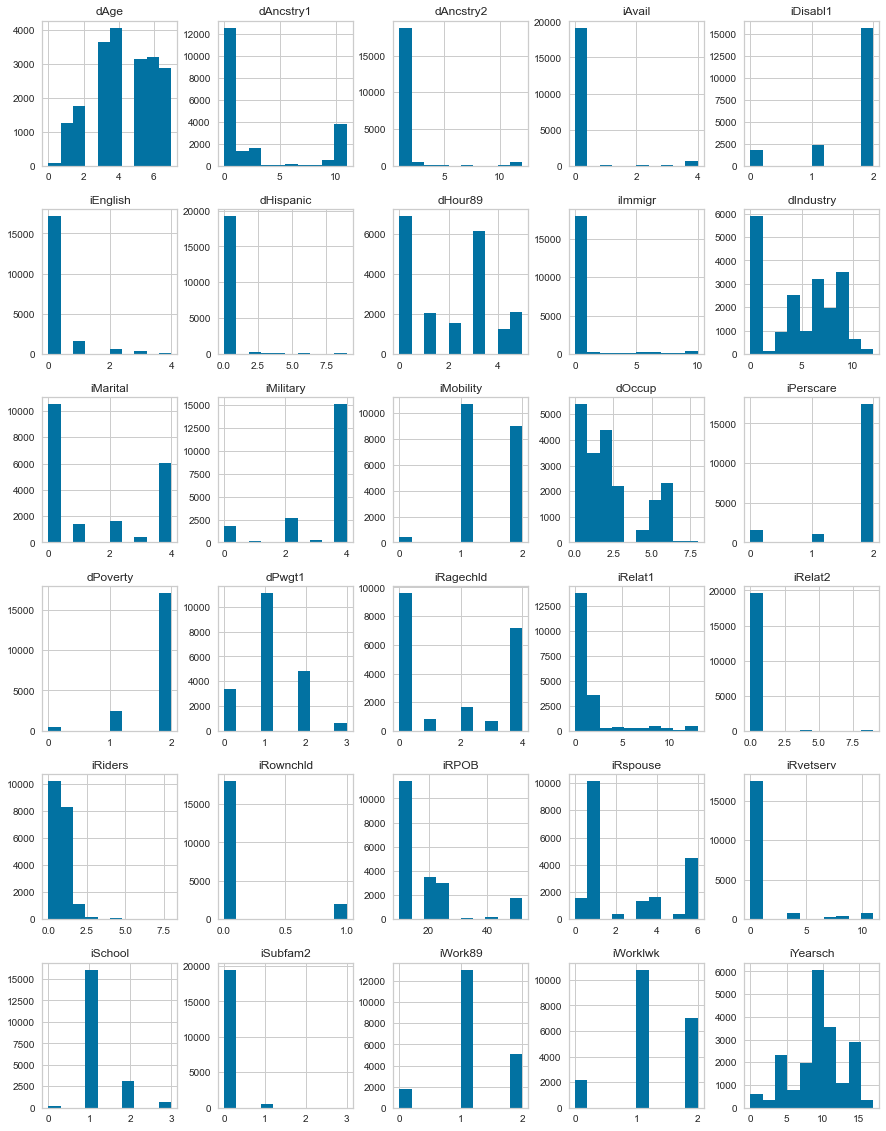

In [33]:
df.hist(figsize=(15,20))
plt.show()

Możemy zauważyć, że większość zmiennych ma bardzo nierównomierny rozkład, w którym przeważa jedna lub dwie wartości. 

### Skalowanie

W naszej ramce, również po redukcji zmiennych, znajduje się wiele kolumn, które nie wyrażają żadnego naturalnego porządku, np. kolumna `iMarital`, która mówi o stanie cywilnym danej osoby - nie da się ustawić ich w jednoznacznym porządku. Dlatego tego typu kolumny zakodujemy korzystając z częstości ich wystąpienia. Każdej wartości w kolumnie przyporządkujemy liczność tej wartości w próbce.  

In [34]:
features_to_scale = ['iAvail', 'iDisabl1', 'dHispanic', 'dIndustry', 'iMarital', 'iMilitary', 'iMobility', 'dOccup', 'iPerscare', 'iRagechld', 'iRelat1',  'iRelat2', 'iRownchld', 'iRPOB', 'iRspouse', 'iRvetserv', 'iSubfam2', 'iWork89', 'iSchool']

In [35]:
for name in features_to_scale:
    tmp = pd.DataFrame(df[name].value_counts())
    dct = dict(pd.Series(tmp[name], tmp.index))
    df.replace({name: dct}, inplace = True)

Następnie, aby znormalizować naszą ramkę danych, postanowiliśmy przeskalować dane, aby zawierały się tylko w zbiorze [0,1]. Zmienne nadal pozostaną dyksretne, ale będzie zdecydowanie łatwiej analizować dobierane klastry w późniejszych krokach. Dodatkowo każda ze zmienne będą zrównoważone, nie będzie kilku silnie dominujących. Mamy na uwadze to, że takie skalowanie zmieni dobór klastrów, bo odległości między punktami będą ewaluowane inaczej. 

In [36]:
for col in df.columns:
    min_max_scaler1 = MinMaxScaler()
    scaled_col1 = min_max_scaler1.fit_transform(df[col].values.reshape(-1, 1))
    df[col] = scaled_col1

In [37]:
df.head()

,dAge,dAncstry1,dAncstry2,iAvail,iDisabl1,iEnglish,dHispanic,dHour89,iImmigr,dIndustry,...,iRiders,iRownchld,iRPOB,iRspouse,iRvetserv,iSchool,iSubfam2,iWork89,iWorklwk,iYearsch
1043419,0.571429,0.272727,1.0,0.034018,1.000000,0.0,1.0,0.0,0.0,0.363841,...,0.000,1.0,1.000000,0.420885,1.000000,1.000000,1.0,0.28913,1.0,0.470588
1788281,1.000000,1.000000,0.0,1.000000,0.041356,0.0,1.0,0.0,0.0,1.000000,...,0.000,1.0,0.188474,1.000000,1.000000,1.000000,1.0,0.28913,1.0,0.294118
2007264,0.428571,0.181818,0.0,1.000000,1.000000,0.0,1.0,0.2,0.0,0.646079,...,0.125,1.0,0.136714,1.000000,1.000000,0.181772,1.0,1.00000,0.5,0.764706
1539732,1.000000,0.090909,0.0,1.000000,1.000000,0.0,1.0,0.4,0.0,0.646079,...,0.000,1.0,0.188474,1.000000,0.046562,1.000000,1.0,1.00000,0.5,0.882353
1416737,0.571429,0.090909,0.0,1.000000,1.000000,0.0,1.0,0.0,0.0,1.000000,...,0.000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,0.28913,1.0,0.823529


## Modelowanie

#### Metoda łokcia

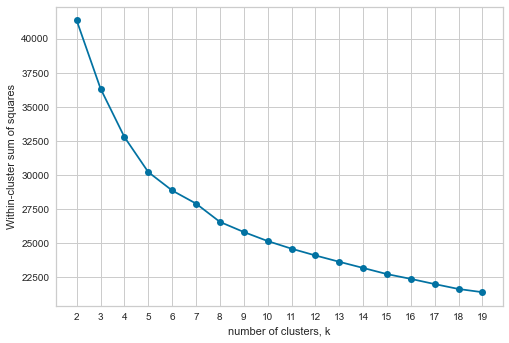

In [38]:
clus_num = range(2, 20)
scores = []

for k in clus_num:
    model = KMeans(n_clusters = k)
    model.fit(df)
    scores.append(model.score(df) * -1)
    
plt.plot(clus_num, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Within-cluster sum of squares')
plt.xticks(clus_num)
plt.show()

Na początek zbadaliśmy metodą łokcia, jaka liczba klastrów będzie optymalna. Wykres scorów dla liczby klastrów od 2 do 20 jest słabo stromy, więc trudno wybrać jednoznacznie punkt przegięcie. Ustalmy jednak, ze znajduje się on w okolicach wartośći od 5 do 9
#### Metoda Silhouette

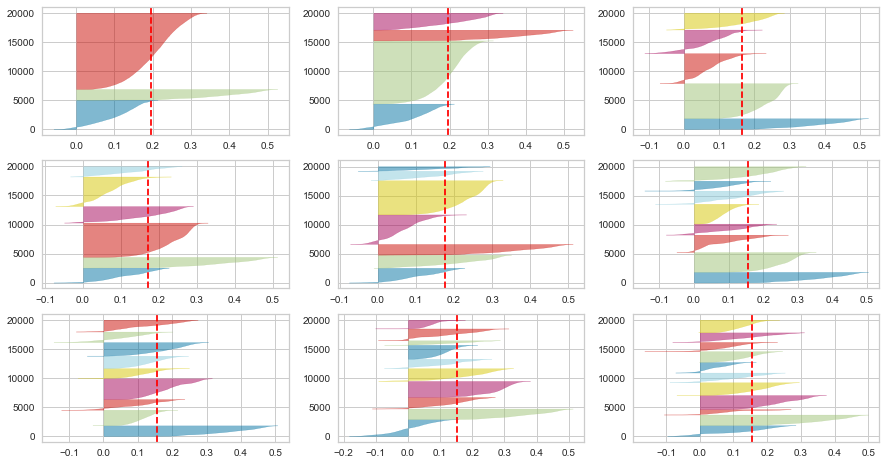

In [39]:
fig, ax = plt.subplots(3, 3, figsize=(15,8))
for i in range(3, 12):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 3)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)

Z powyższego wykresu wydaje się że 7 klastrów dość prawidłowo powinno skategoryzować rekordy.

***
***

Uznaliśmy, ze dobrą metodą na wizualizacje jak model dzieli dane na klastry, jest wykorzystanie centroidów i porównywanie ich w zależności od klastra dla każdej ze zmiennych. Do analizy wykorzystamy zaimplementowane poniżej funkcje.

In [40]:
def CentroidsMean(labs):
    '''
    Funkcja, która na podstawie wektora klastrów 
    wylicza średnie centroidów każdej zmiennej 
    w każdym klastrze. Zwraca ramkę danych.
    '''
    colnames = df.columns
    centr = pd.DataFrame(columns = colnames)
    tmp = df.assign(labs = y)
    for clust in np.sort(np.unique(labs)):
        segments = tmp[tmp.labs == clust].drop('labs', axis = 1)
        means = segments.mean().values
        centr.loc[clust]= means
    return centr

def CentroidsPlot(centroids):
    '''
    Funkcja, która tworzy wykres centroidów 
    dla wszytskich zmiennych i klastrów na
    podstawie ramki opisującej centroidy.
    '''
    cent_df = pd.DataFrame(columns= ['cluster', 'variable', 'centroid'])
    rows = centroids.shape[0]
    clusters = [x+1 for x in range(rows)]
    for colname in centroids.columns:
        data = {'cluster' : clusters,
               'variable' : [colname for x in range(rows)],
               'centroid' : centroids[colname]}
        cent_df = pd.concat([cent_df, pd.DataFrame(data)])
    plt.figure(figsize=(18, 8))
    scatter = plt.scatter(cent_df.variable, cent_df.centroid, c=cent_df.cluster, cmap='viridis', s = 200, alpha = 0.7)
    plt.legend(handles=scatter.legend_elements()[0], 
           labels=clusters,
           title="cluster")
    plt.xticks(rotation = 90, fontsize = 15)

In [41]:
#Proba sprawdzenia wariancji klastrów dla każdej ze zmiennych

# def clusterSummary(centroids, labs):
#     col_names = df.columns
#     df['labs'] = labs
#     for name in col_names:
#         cent_var

### KMeans
Na początek zbudujemy modele KMeans dla znalezionych wcześniej optymalnych liczb klastrów

In [42]:
model = KMeans(n_clusters = 5)
model.fit(df)
labs = model.labels_
centroids = model.cluster_centers_
centroids = pd.DataFrame(columns = df.columns, data = centroids)

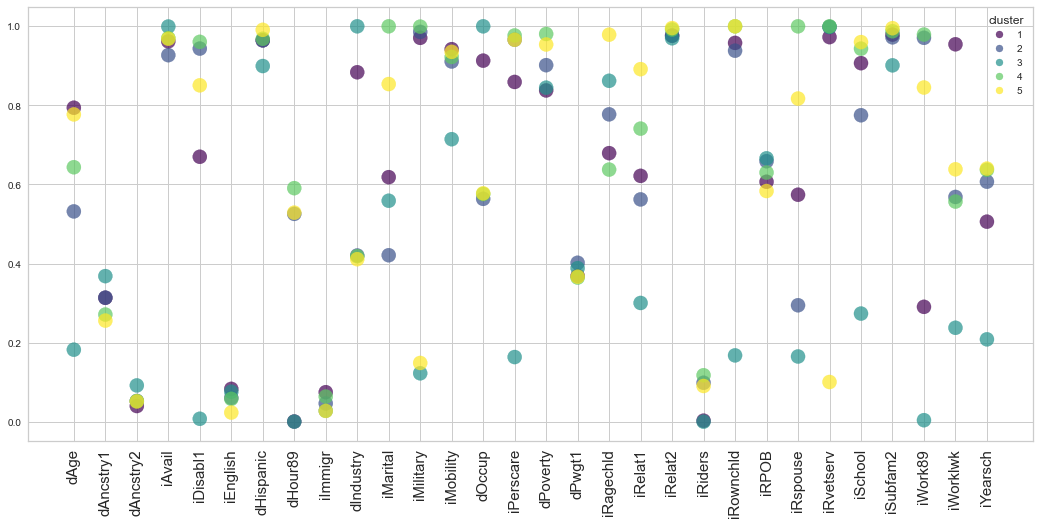

In [43]:
CentroidsPlot(centroids)

In [44]:
model = KMeans(n_clusters = 7)
model.fit(df)
labs = model.labels_
centroids = model.cluster_centers_
centroids = pd.DataFrame(columns = df.columns, data = centroids)

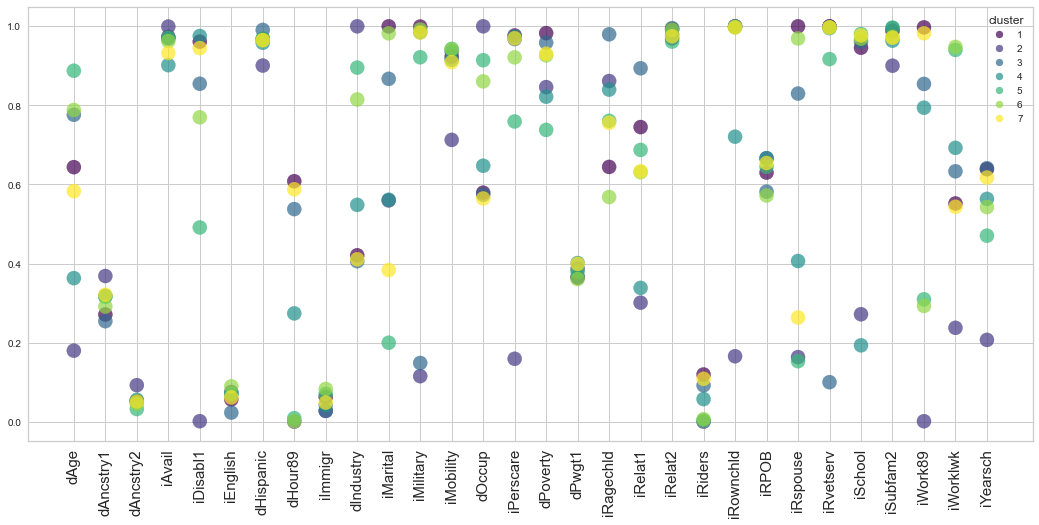

In [45]:
CentroidsPlot(centroids)

In [46]:
model = KMeans(n_clusters = 9)
model.fit(df)
labs = model.labels_
centroids = model.cluster_centers_
centroids = pd.DataFrame(columns = df.columns, data = centroids)

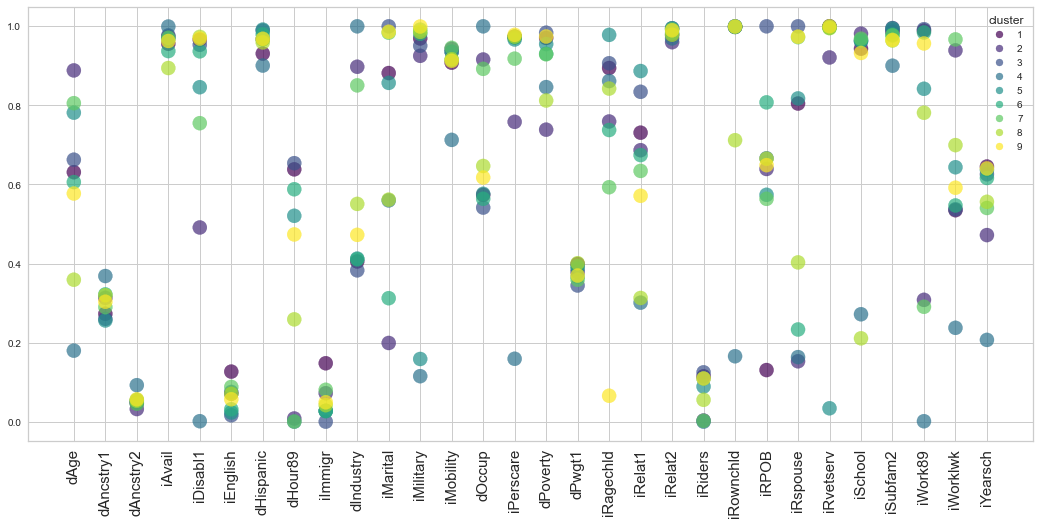

In [47]:
CentroidsPlot(centroids)

Widać, że dobór większej liczby klastrów sprawia problemy, ponieważ kolejne klastry są do siebie za bardzo zbliżone. Dla 5 klastrów widać, że grupy mają różne dobrane centroidy, przez co wydaje się, że rzeczywiście dobrze rozdzielają rekory na różne klastry. Na pewno widać, że klaster oznaczony jako 3 dobrze oddziela młodzież i dzieci, natomiast klaster 4 ludzi starszych.

### Klasteryzacja hierarchiczna 

Teraz sprawdzimy jak na naszym zbiorze poradzi sobie metoda algomeracyjna klasteryzacji z wykorzystaniem progu odległości.

In [48]:
Z = hierarchy.linkage(df, method='ward')

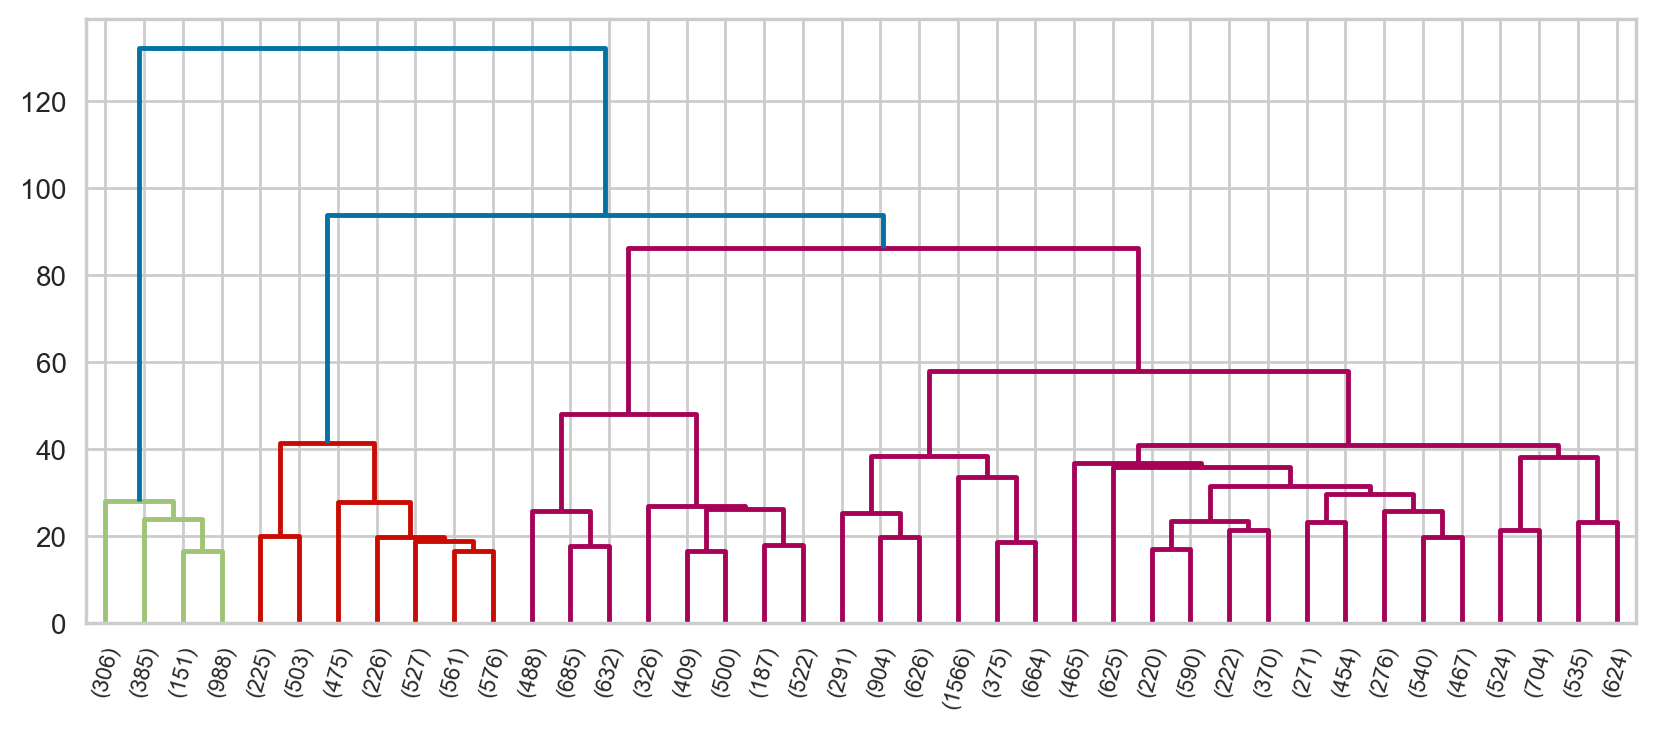

In [49]:
plt.figure(figsize=(10, 4), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z, p=40, truncate_mode='lastp', leaf_rotation=75)
plt.show()

Z dendogramu można wywnioskować, że najlepsza liczba klastrów dla metody aglomeracyjnej to 3 lub 4. 

In [50]:
model = AgglomerativeClustering(n_clusters=3, linkage='ward')
y = model.fit_predict(df)

In [51]:
centroids = CentroidsMean(y)

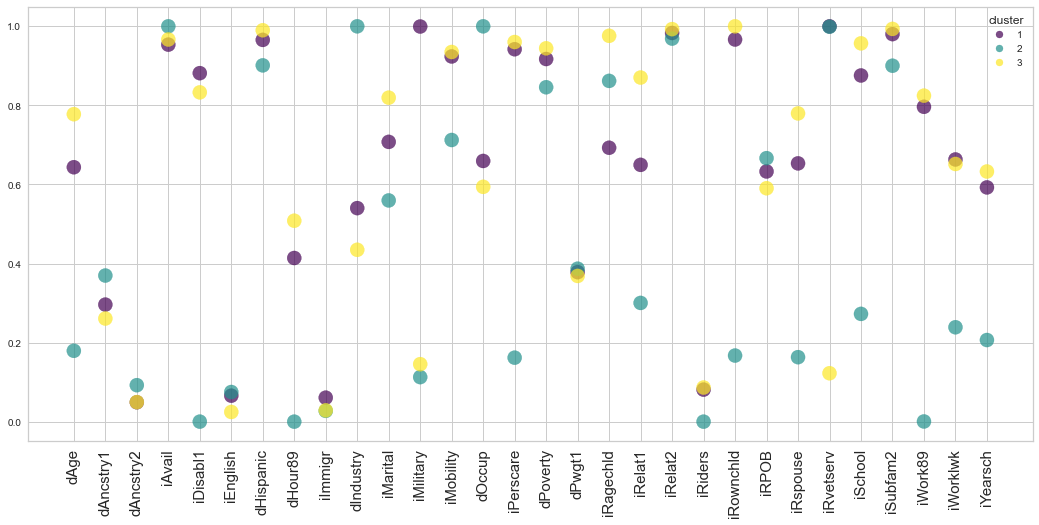

In [52]:
CentroidsPlot(centroids)

In [53]:
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
y = model.fit_predict(df)

In [54]:
centroids = CentroidsMean(y)

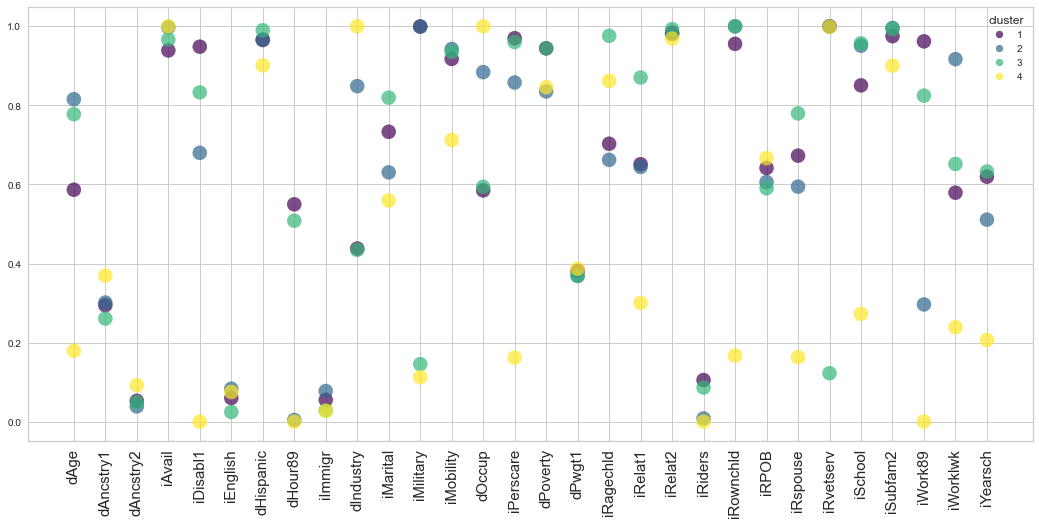

In [55]:
CentroidsPlot(centroids)

In [56]:
model = AgglomerativeClustering(n_clusters=5, linkage='ward')
y = model.fit_predict(df)

In [57]:
centroids = CentroidsMean(y)

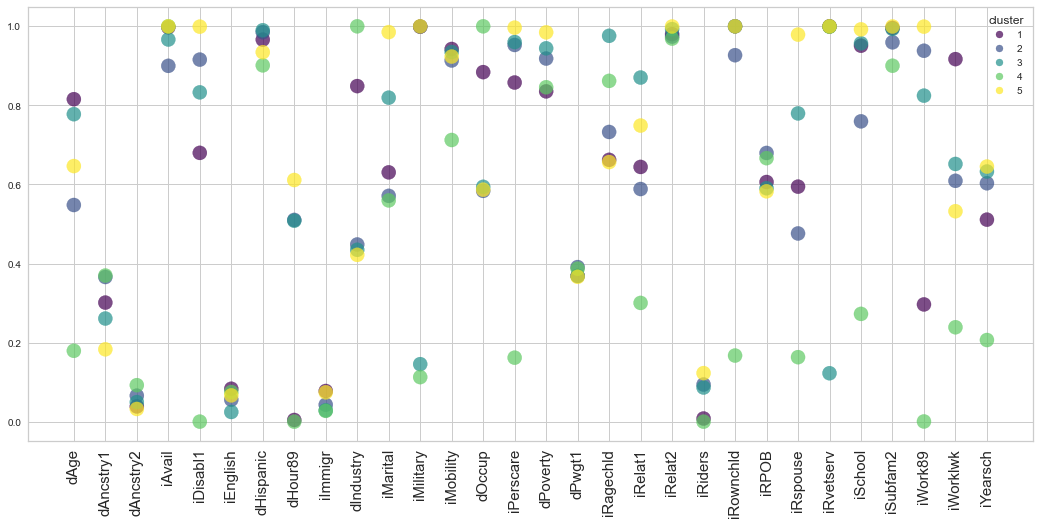

In [58]:
CentroidsPlot(centroids)

Analizując wykresy centroidów, można dojść do wniosku, że metoda aglomeracyjna także dobrze dzieli klastry. Porównując wyniki, dla 3 klastrów widać, że 4 grupa jest potrzebna bo w zbiorze występują jeszcze rozbieżności, natomiast w przypadku 5 klastrów można zauważyć, że niekóre z nich zaczynają być zbyt zbliżone. Wydaje się więc, że najlepszy rezultat uzyskaliśmy dla liczby klastrów 4.

### DBSCAN

Sprawdzimy jeszcze jak z problemem klasteryzacji w tym przypadku poradzi sobie algorytm DBSCAN. Na początek znajdziemy optymalną wartość parametru epsilon.

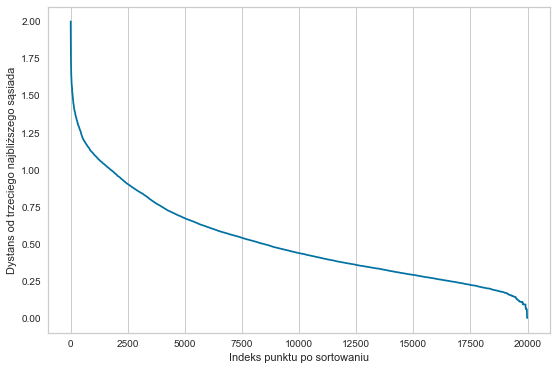

In [59]:
minPts = 5
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(df)
distances, indices = nbrs.kneighbors(df)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,df.shape[0]+1)), distanceDec)

#plt.xscale('log')

plt.grid(axis='y')

plt.show()

Wykres nie daje jednoznacznych wyników. Można się spodziewać, że epsilon na poziomie 0.5-2.0 będzie odpowiedni.

In [60]:
eps = 1
dbs = cluster.DBSCAN(eps=eps, min_samples=minPts)
dbs.fit(df)

DBSCAN(eps=1)

In [61]:
y = dbs.labels_
np.sort(pd.unique(y))

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21], dtype=int64)

Dla epsilona równego 1 algorytm utworzył 113 klastrów. To zdecydowanie za dużo. 

In [62]:
eps = 1.5
dbs = cluster.DBSCAN(eps=eps, min_samples=minPts)
dbs.fit(df)

DBSCAN(eps=1.5)

In [63]:
y = dbs.labels_
np.sort(pd.unique(y))

array([-1,  0], dtype=int64)

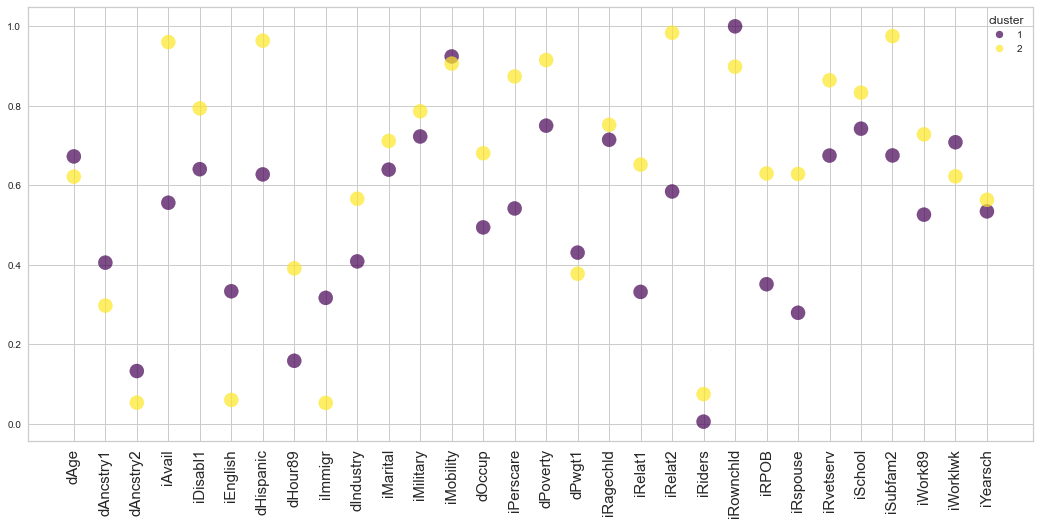

In [64]:
centroids = CentroidsMean(y)
CentroidsPlot(centroids)

Dal epsilona równego 1.5 algorytm znalazł już tylko 4 klastry. Z analizy wykresu wynika, że także w przypadku DBSCAN da się znaleźć kolumny, które wyraźnie charakteryzują poszczególne grupy.

### Wybór najlepszego modelu

Naszym zdaniem najlepszy jest model X o Y klastrach, ponieważ wydaje się, że dobrze rozdziela zbiór na grupy o zróżnicowanych cechach. BLAH BLAH...

***
***
***

## Analiza klastrów

Opórcz tego wykresiku, może jeszcze zrobię tabelę z wariancją centroidów, i na przykład rozkłady tych zmiennych które najbardziej rozdzielają klastry w zależności od klastra, żeby zobaczyć czy np. w klastrze jest dużo żon i mężów a w klastrze 3 jest dużo dzieci. Ale tylko dla jednego modelu, bo nie chce mi się więcej, dlatego wcześniej wybór tego najlepszego.